In [1]:
import pandas as pd
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('dataset.csv')
m = df.shape[0]

In [13]:
def getDay(b):
    day = b.split('d')[1][0]
    return int(day)

In [14]:
def cases(b):
    line = df[(df['Block'] == b)]
    return list(line['Beds'])

In [22]:
import gurobipy as gp
from gurobipy import GRB

# Define sets
W = df['Weekday'].unique()            #weekday
N = df['Week Number'].unique()        #OR
O = df['ORs'].unique()                #OR
B = df['Block'].unique()              #Block
S = df['Surgeon ID'].unique()         #Surgeon

F = ['1']
peak = 338

# Create a new model
model = gp.Model("OR opt")

# Define decision variables
x_p = model.addVars(B, B, vtype=GRB.BINARY, name="x_p")  # Allowed Moves
z = model.addVars(F, vtype=GRB.INTEGER, name="z")

summed_values = model.addVars(W, N, vtype=GRB.INTEGER, name="sum_var") # Total bed counts for weekday d in week i


# Define constraint

# Additional (not from original paper)

for b1 in B:  # This constraint makes sure that each block can only move to one place
    model.addConstr(gp.quicksum(x_p[b1,b2] for b2 in B) == 1)

# (2)

for b2 in B:
    model.addConstr(gp.quicksum(x_p[b1,b2] for b1 in B) == 1)

# (3)

for f in F:
    for d in W: # Weekday
        for i in N:
            model.addConstr(sum(cases(b1)[i-1] * x_p[b1, b2] for b1 in B for b2 in B if getDay(b2) == d) == summed_values[d, i])
        for i in N:
            model.addConstr(summed_values[d, i] <= z[f])

# (4)

# for s in S:
#     for i in N:
#         for d in W:

#             block_count = df[(df['Block'] == b)]


model.setObjective(sum(peak - z[f] for f in F), GRB.MAXIMIZE)

# Optimize the model
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 784 rows, 132525 columns and 795060 nonzeros
Model fingerprint: 0x07640b8d
Variable types: 0 continuous, 132525 integer (132496 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.77s
Presolved: 784 rows, 132525 columns, 680400 nonzeros
Variable types: 0 continuous, 132525 integer (132496 binary)
Found heuristic solution: objective 1.0000000
Found heuristic solution: objective 14.0000000
Found heuristic solution: objective 19.0000000

Root relaxation: objective 2.385714e+01, 1506 iterations, 0.61 seconds (1.61 work units)
Total elapsed time = 7.01s (DegenMoves)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

In [15]:
# Print result
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found!")

    # Print z values
    print("\nOptimal values for z:")
    for f in F:
        print(f"z[{f}] = {z[f].x}")

    print("\nOptimal moves (x_p):")
    for d in W:
        for i in N:
            print(f"sum_value[{d}, {i}] = {summed_values[d, i].x}")

    # Print x_p values where x_p[b1, b2] = 1 (i.e., movement occurs)
    print("\nOptimal moves (x_p):")
    for b1 in B:
        for b2 in B:
            if x_p[b1, b2].x > 0.5:  # Binary, so check if it's 1
                print(f"x_p[{b1}, {b2}] = {int(x_p[b1, b2].x)}")
else:
    print("\nNo optimal solution found.")


Optimal Solution Found!

Optimal values for z:
z[1] = 315.0
sum_value[1, 1] = 315.0
sum_value[1, 2] = 315.0
sum_value[1, 3] = 315.0
sum_value[1, 4] = 315.0
sum_value[2, 1] = 315.0
sum_value[2, 2] = 315.0
sum_value[2, 3] = 315.0
sum_value[2, 4] = 315.0
sum_value[3, 1] = 315.0
sum_value[3, 2] = 315.0
sum_value[3, 3] = 315.0
sum_value[3, 4] = 315.0
sum_value[4, 1] = 315.0
sum_value[4, 2] = 315.0
sum_value[4, 3] = 315.0
sum_value[4, 4] = 315.0
sum_value[5, 1] = 315.0
sum_value[5, 2] = 315.0
sum_value[5, 3] = 315.0
sum_value[5, 4] = 315.0
sum_value[6, 1] = 315.0
sum_value[6, 2] = 315.0
sum_value[6, 3] = 315.0
sum_value[6, 4] = 315.0
sum_value[7, 1] = 315.0
sum_value[7, 2] = 315.0
sum_value[7, 3] = 315.0
sum_value[7, 4] = 315.0

Optimal moves (x_p):
x_p[(d1,o1), (d2,o51)] = 1
x_p[(d2,o1), (d7,o23)] = 1
x_p[(d3,o1), (d2,o24)] = 1
x_p[(d4,o1), (d3,o9)] = 1
x_p[(d5,o1), (d3,o48)] = 1
x_p[(d6,o1), (d2,o25)] = 1
x_p[(d7,o1), (d7,o27)] = 1
x_p[(d1,o2), (d4,o20)] = 1
x_p[(d2,o2), (d6,o30)] = 1
x_p

# Get Result

In [16]:
def casesWeek(b):
    line = df[(df['Block'] == b)]
    return list(line['Beds']), list(line['Week Number'])

# cases('(d2,o4)')

[6, 6, 6, 6]

In [17]:
def getDayOR(b):
    day = b.split('d')[1][0]
    room = b.split('o')[1][0]
    return int(day), int(room)

# getDayOR('(d2,o4)')

(2, 4)

In [21]:
# Apply rearrangement
df_rearrange = df.copy()

rearrangements = []
new_bed = np.zeros(m, dtype='int')

for b1 in B:
    for b2 in B:
        if x_p[b1, b2].x > 0.5:  # Binary, so check if it's 1
            # Log all pairs of b1 and b2
            rearrangements.append([b1,b2])

# Moving beds value from original dataset to new dataset according to resulting moves.
for bs in rearrangements:
    b1 = bs[0]
    b2 = bs[1]
    bed, week_num = casesWeek(b1)
    d2, o2 = getDayOR(b2)
    for i in range(4):
        line_idx = df[(df['Block'] == b2) & (df['Week Number'] == week_num[i])].index
        new_bed[line_idx[0]] = bed[i]

df_rearrange['Beds'] = new_bed

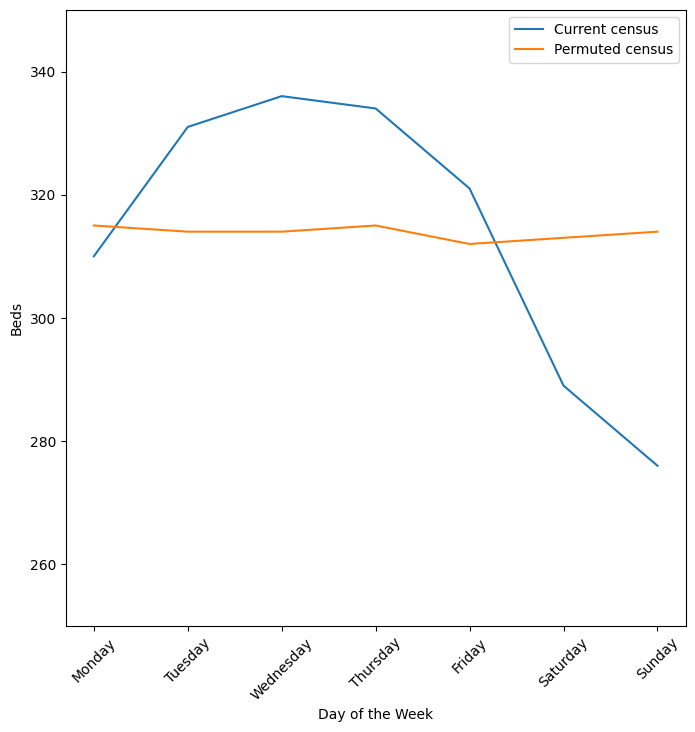

In [19]:
week = 1
weekn = df['Week Number'] == week
weekn
df_weekn = df[weekn]
df_weekn

weekday_daycount = []
for d in range(1, 8):
    day_count = df_weekn[df_weekn['Weekday'] == d]['Beds'].sum()
    weekday_daycount.append(day_count)

weekday_daycount

weekn_re = df_rearrange['Week Number'] == week
df_weekn_re = df_rearrange[weekn_re]

weekday_daycount_re = []
for d in range(1, 8):
    day_count = df_weekn_re[df_weekn_re['Weekday'] == d]['Beds'].sum()
    weekday_daycount_re.append(day_count)



# Define labels for better readability
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Count occurrences of each day
day_counts = weekday_daycount
day_counts_re = weekday_daycount_re

# Plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.plot(range(7), day_counts, label='Current census')
plt.plot(range(7), day_counts_re, label='Permuted census')

# Set labels
plt.xticks(ticks=range(7), labels=day_labels, rotation=45)
plt.xlabel("Day of the Week")
plt.ylabel("Beds")
plt.ylim(250, 350)
plt.legend()

# Show plot
plt.show()